In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_sigma_e

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from ising_model import SimulateMH

from scipy import signal

In [2]:
%%timeit
_,_,Ms, Es, engine = to_run(1, 1_000_000, T=0.1, N=32, M=1, freq=1, 
                            SEED=15, return_engine=True, 
                            init="random")

121 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [3]:
TTc = 2/np.log(1+np.sqrt(2))

In [4]:
pool = Pool(32)

In [5]:
with open("heat-capac-4-44-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)
NtoT[2] = 2.51

In [6]:
Ns = [2]
n = Ns[0]
eps = 0.001
while n < max(NtoT.keys()):
    if abs(NtoT[n] - NtoT[Ns[-1]]) > eps:
        Ns.append(n)
    n+=1

47


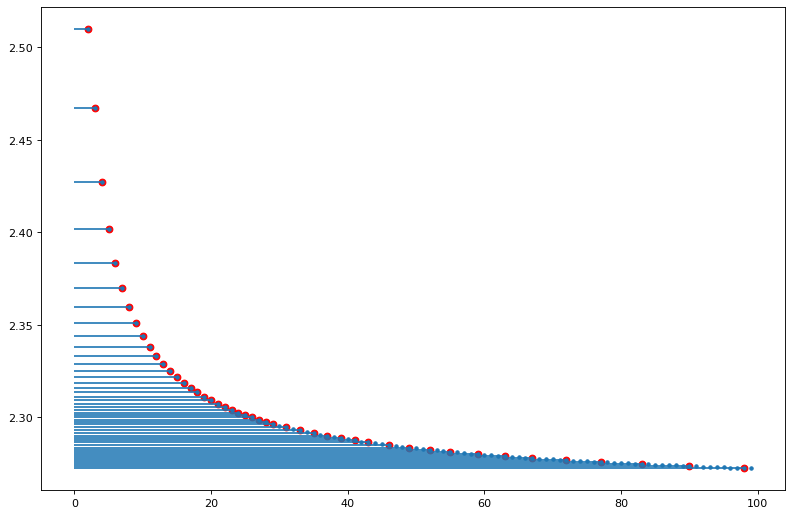

In [7]:
plt.plot(list(NtoT.keys()), list(NtoT.values()), ".")

for n in Ns:
    plt.scatter(n, NtoT[n], c="r")
    plt.hlines(y = NtoT[n], xmin=0, xmax=n)
print(len(Ns))

In [8]:
34*10/512/60*2048

22.666666666666668

In [9]:
results = []
for N in Ns:
    TcN = NtoT[N]
    Ts = np.linspace(TcN-0.05, TcN+0.05, 4096)
    for Ts1 in tqdm(Ts.reshape(32, 64*2)):
        runs = len(Ts1)
        res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
                zip(*(Ts1,
                      [N]*runs, # N
                      [4*10**7]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                          )),
    #             chunksize=1
            )
        results+= res

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
with open("heat-capac-2-96-1e7-4096.pkl", "wb")as f:
    pickle.dump(results, f)

In [ ]:
with open("heat-capac-2-96-1e7-4096.pkl", "rb") as f:
    results = pickle.load(f)

In [13]:
len(results)/4096

47.0

In [12]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

In [14]:
gb = df.groupby("N")

In [15]:
def find_peak(vals, l=5, r=30):
    pids = []
    for w in range(l,r):
        smooth =  np.convolve(vals, np.ones(w), mode="same")/w
        pids.append(np.argmax(smooth))
    return int(np.median(pids))

14 Optimal parameters not found: Number of calls to function has reached maxfev = 3000.


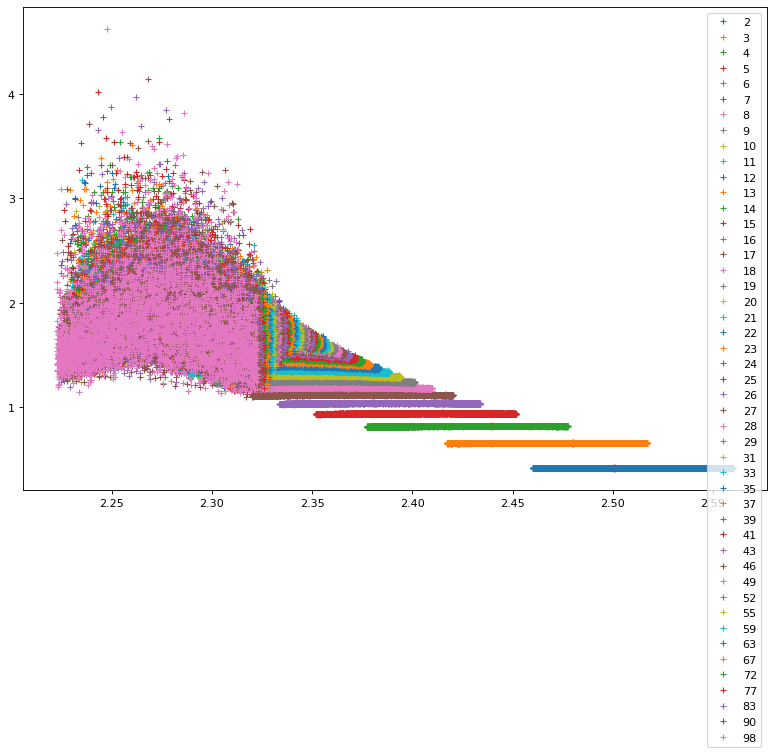

In [16]:
Ns = []
Tcs1 = []
Tcs2 = []
Tcs3 = []
Tcs3_err = []

for N in gb.groups:
    Ns.append(N)
    
    df4 = gb.get_group(N)
    plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")
    
    pid = find_peak(df4.C, l=5, r=30)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
    
    Tcs1.append(df4.temp.iloc[pid])
    
    pid = find_peak(df4.C, l=10, r=60)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=10)
    
    Tcs2.append(df4.temp.iloc[pid])
    def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
    try:
        popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=3000, 
                                  p0=[TTc+0.3, 1.5, 1])
        Tcs3.append(popt[0])
        Tcs3_err.append(popt_cov[0,0]**0.5)
        
    except Exception as e:
        Tcs3.append(np.nan)
        Tcs3_err.append(np.nan)
        print(N, e)
    
plt.legend()

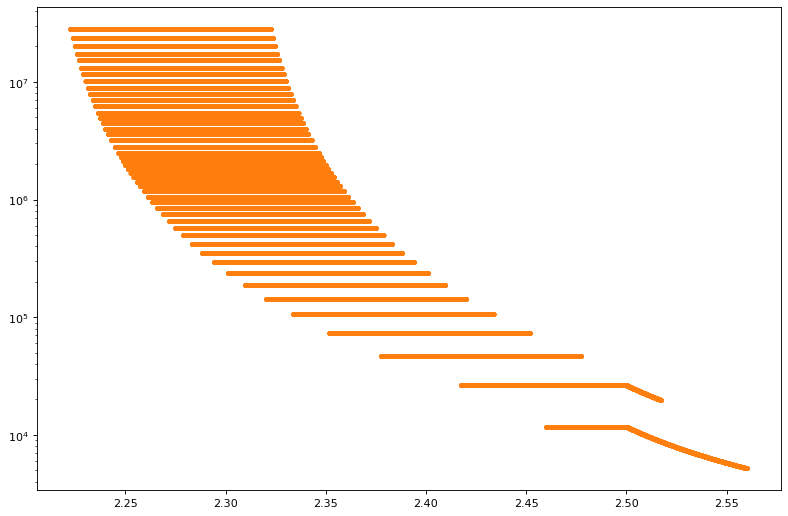

In [17]:
plt.plot(df.temp, df.pos1, ".")
plt.plot(df.temp, df.pos2, ".")
plt.gca().set_yscale("log")

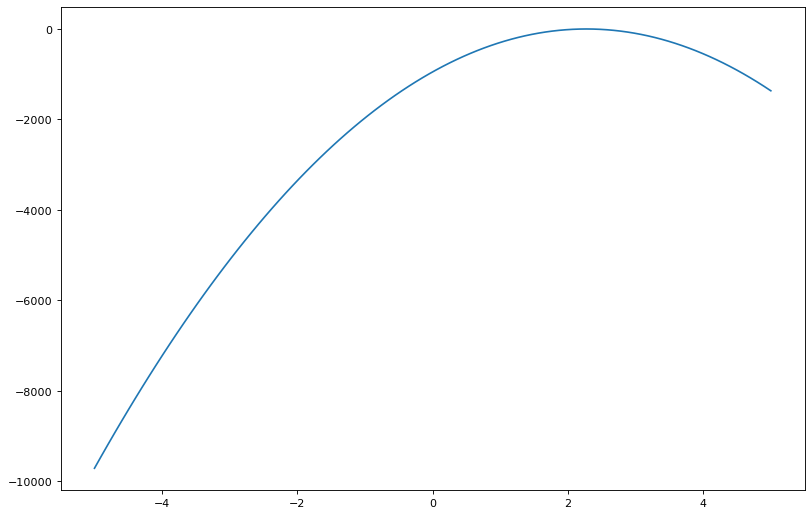

In [19]:
xs = np.linspace(-5,5,100)
plt.plot(xs, f(xs, *popt))

In [97]:
popt

array([ 9.24191846e-01,  1.01141075e+02, -3.83340587e+03, -7.21063541e+01])

In [20]:
df4 = gb.get_group(60)
plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")

def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=3000, 
                                  p0=[TTc+0.3, 1.5, 1])
plt.plot(df4.temp, f(df4.temp, *popt))
plt.scatter(popt[0], f(popt[0], *popt), c="g", s=80)

pid = find_peak(df4.C, l=5, r=30)
plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
pid = find_peak(df4.C, l=10, r=60)
plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=15)

KeyError: 60

In [141]:
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))
popt1, popt1_cov = curve_fit(f, Ns, Tcs1)
popt2, popt2_cov = curve_fit(f, Ns, Tcs2)
popt3, popt3_cov = curve_fit(f, Ns, Tcs3, sigma=np.array(Tcs3_err))

In [142]:
Tc, a, mu = popt1
print(f"T={Tc:0.3f} a={a:0.3f} mu={mu:0.3f}")
Tc_err, a_err, mu_err = np.sqrt(popt1_cov.diagonal())
print(f"T={Tc_err:0.6f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.240 a=0.432 mu=1.655
T=0.009812 a=0.013579 mu=0.140050


In [183]:
l,r=5,-5
popt3, popt3_cov = curve_fit(f, Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a, mu = popt3
print(f"T={Tc:0.4f} a={a:0.3f} mu={mu:0.3f}    Tc = {TTc:0.5f}")
Tc_err, a_err, mu_err = np.sqrt(popt2_cov.diagonal())
print(f"T={Tc_err:0.4f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.2639 a=0.597 mu=1.152    Tc = 2.26919
T=0.0087 a=0.012439 mu=0.124375


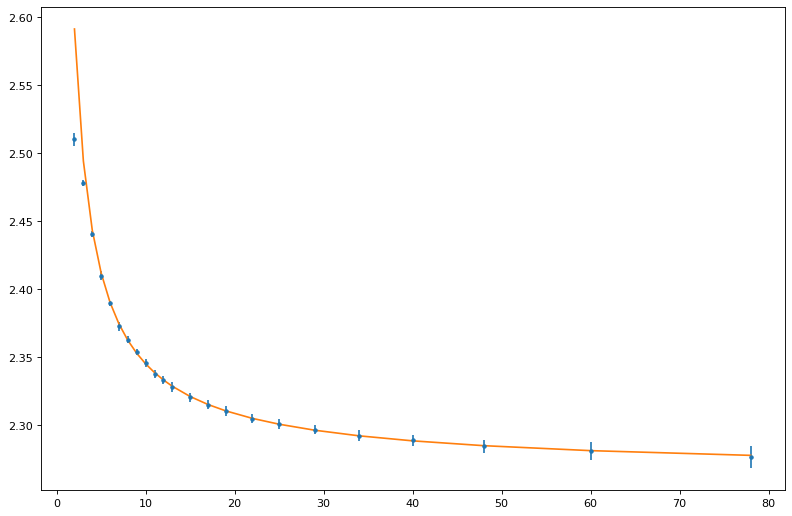

In [184]:
# plt.plot(Ns, Tcs1, "+")
# plt.plot(Ns, Tcs2, "+")
plt.errorbar(Ns, Tcs3, yerr=np.array(Tcs3_err)*10, fmt=".")
# plt.plot(Ns, f(np.array(Ns), *popt1))
plt.plot(Ns, f(np.array(Ns), *popt3))